### Categorical / Interval Variables

In [1]:
%%capture

%run '../lib/libraries.ipynb'
from ..lib import utilities as util
from pyspark.sql import functions as F

In [2]:
filterDf  = util.load_df('filterDf')
descDf = util.load_df('descDf')
types = util.get_var_types()

#### Variable List

In [3]:
util.variable_types(descDf, 'Categorical Interval')

,category,variable
0,Assignment (a),assignment_due_date
1,Assignment (a),assignment_final_submission_date
2,Assignment (a),assignment_start_date
3,Assignment (a),max_student_stop_datetime
4,Assignment (a),min_student_start_datetime
5,Assignment Attempt (aa),scored_datetime
6,Assignment Attempt (aa),student_start_datetime
7,Assignment Attempt (aa),student_stop_datetime
8,Assignment Attempt (aa),was_fully_scored_datetime
9,Assignment Attempt (aa),was_in_progress_datetime


#### Statistics

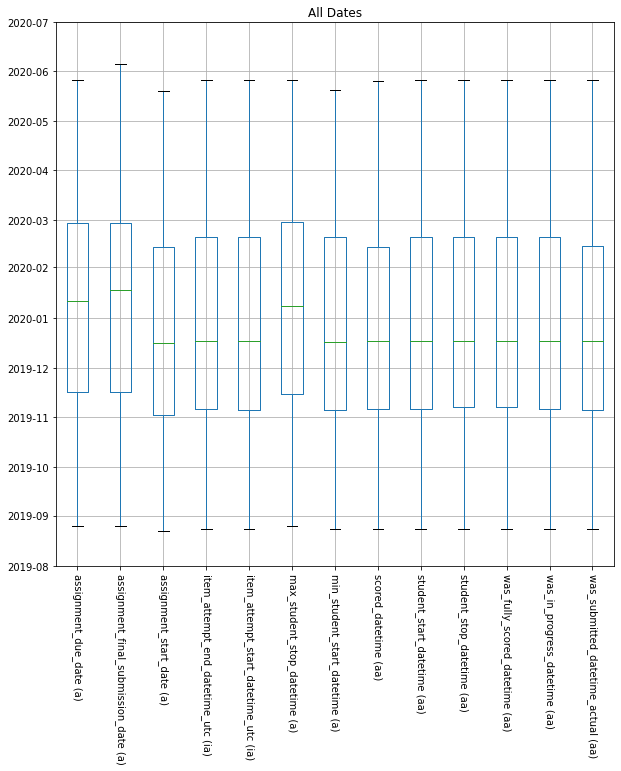

In [4]:
util.date_boxplot(util.get_random_sample(filterDf), "All Dates")

- Normally distributed
- Range 8/15/2019 - 6/1/2020
- Median between 12/15/2019 and 1/15/2020

###### Relationship with predictor

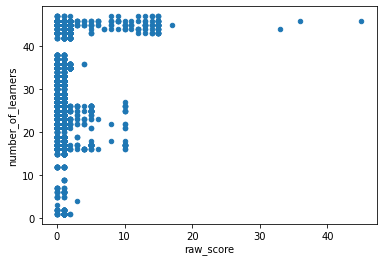

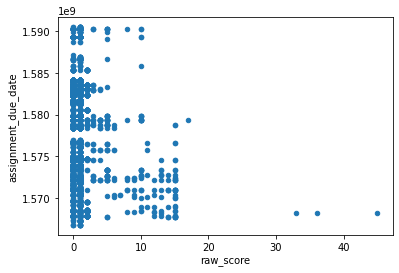

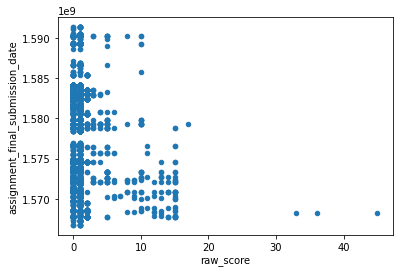

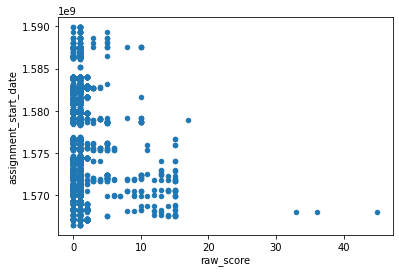

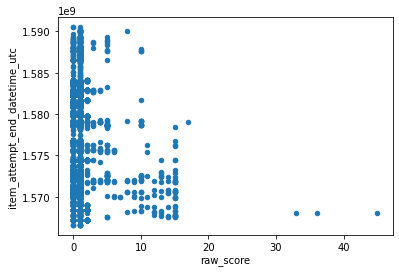

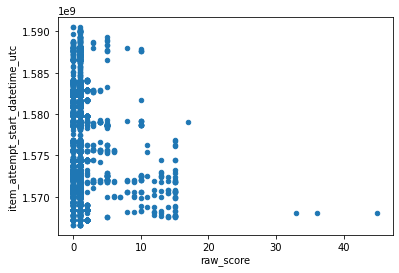

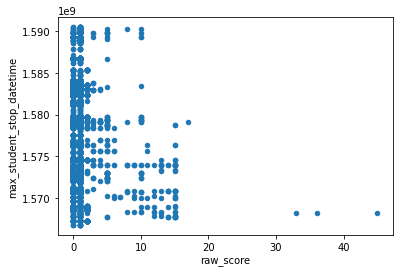

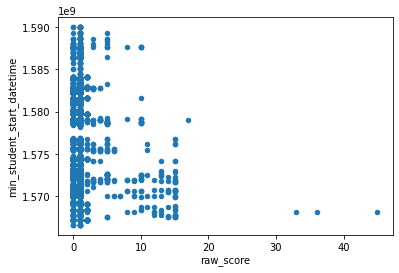

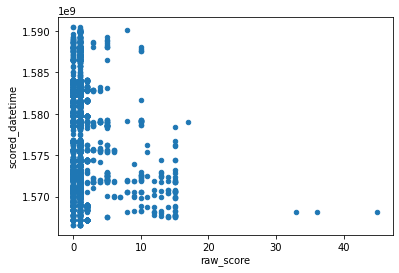

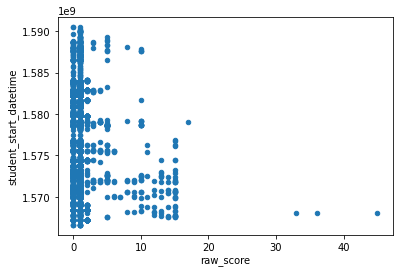

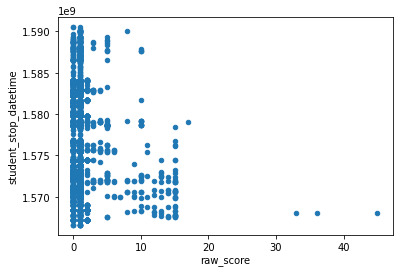

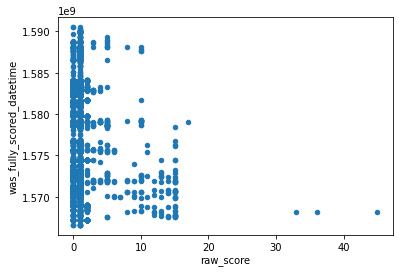

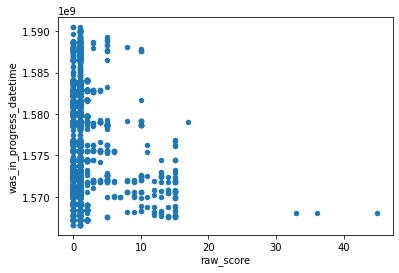

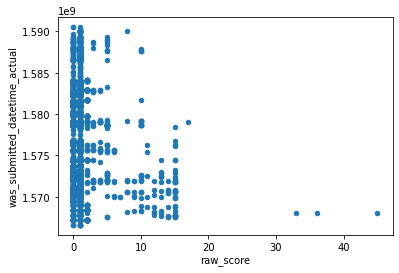

In [5]:
pdDf = util.get_random_sample(filterDf).select('number_of_learners', 'raw_score', * (F.unix_timestamp(c).alias(c) for c in types['intervalVars']) ).toPandas()
pdDf.plot.scatter('raw_score', 'number_of_learners')

for col in types['intervalVars']:
    pdDf.plot.scatter('raw_score', col)

- No relationship found
- Patterns similar amoung variables

In [6]:
dateStats = util.date_statisticts(filterDf, types['intervalVars'])
print ("Range", dateStats['min'].min(), "to", dateStats['max'].max())
dateStats

Range 2019-08-22 to 2020-06-05


,distinct,null,min,max
assignment_due_date,180,1566,2019-08-25,2020-05-26
assignment_final_submission_date,190,1566,2019-08-25,2020-06-05
assignment_start_date,203,1566,2019-08-22,2020-05-19
item_attempt_end_datetime_utc,64352,0,2019-08-23,2020-05-26
item_attempt_start_datetime_utc,59788,0,2019-08-23,2020-05-26
max_student_stop_datetime,508,0,2019-08-25,2020-05-26
min_student_start_datetime,587,0,2019-08-23,2020-05-20
scored_datetime,6577,1438,2019-08-23,2020-05-25
student_start_datetime,6942,437,2019-08-23,2020-05-26
student_stop_datetime,6761,437,2019-08-23,2020-05-26


Date Values
- Dates fall in range of a school year of 8/2019 to 5/2020
- All variables (except 4) have have null dates
- 1566 null dates
    - in
      - assignment_due_date
      - assignment_final_submission_date
      - assignment_start_date
- Verify same observations as 1566 [unassigned] in response_correctness'
- 437 and 438 null dates
    - in
      - student_start_datetime
      - student_stop_datetime
      - was_fully_scored_datetime
- 1438 in scored_datetime
- 459 in was_in_progress_datetime
- 4002 in was_submitted_datetime_actual

In [7]:
util.add_todo('Investigate null assignment dates')
util.add_todo('Investigate null student and scored dates')
util.add_todo('Investigate null dates in scored_datetime')
util.add_todo('Investigate null dates in was_in_progress_datetime')
util.add_todo('Investigate null dates in was_submitted_datetime_actual')

Todo: Investigate null assignment dates
Todo: Investigate null student and scored dates
Todo: Investigate null dates in scored_datetime
Todo: Investigate null dates in was_in_progress_datetime
Todo: Investigate null dates in was_submitted_datetime_actual


###### Correlations Heatmap

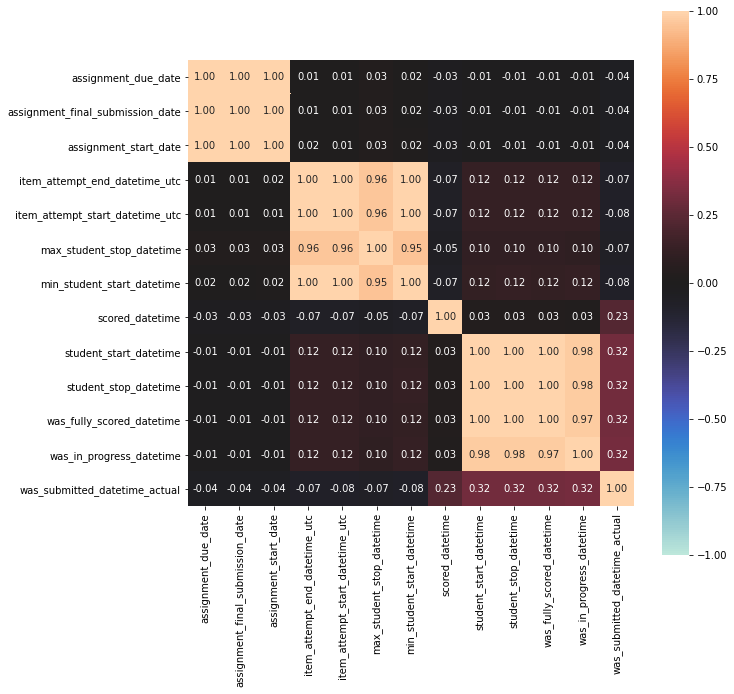

In [8]:
corr, ax = util.associations( filterDf.select(* (F.unix_timestamp(c).alias(c) for c in types['intervalVars']) ).toPandas(), figsize=[10,10] )

- Correlated dates
  - assignment_due_date and assignment_final_submission_date
  - assigment_due_date and assignment_start_date
  - min_student_start_datetime and max_student_start_datetime
  - student_start_datetime and student_stop_datetime
  - student_start_datetime and was_fully_scored_datetime
  - student_stop_datetime and was_fully_scored_datetime
  - item_attempt start and end with was_in_progress and was_submitted datetime
- Correlation appears to be because the events closely follow each other

###### Mean Days Between All Interval Vars

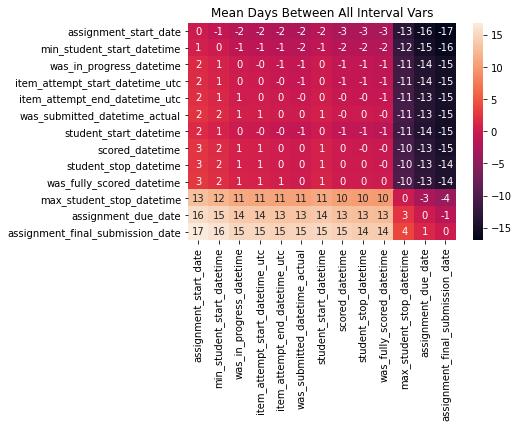

In [9]:
cats = util.get_var_cats()
# Ordered Interval Vars
allIntVars = [
    'assignment_start_date',
    'min_student_start_datetime',
    'was_in_progress_datetime',
    'item_attempt_start_datetime_utc',
    'item_attempt_end_datetime_utc',
    'was_submitted_datetime_actual',
    'student_start_datetime',
    'scored_datetime',
    'student_stop_datetime',
    'was_fully_scored_datetime',
    'max_student_stop_datetime',
    'assignment_due_date',
    'assignment_final_submission_date',
]

sampDf = util.get_random_sample(filterDf)

util.date_diff_map(sampDf.select(allIntVars).toPandas(), "Mean Days Between All Interval Vars", 'D')

###### Mean Hours Between Assignment Interval Vars

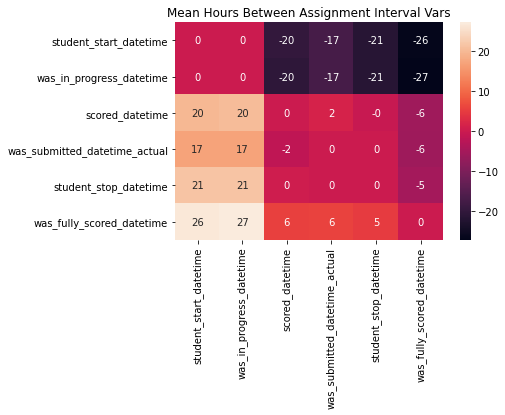

In [10]:
util.mean_hours_assignment_interval(sampDf)

- Sequence of dates
  - student_start_datetime
  - was_in_progress_datetime (+0 hours)
  - item_attempt_start_datetime_utc (+5 hours)
  - item_attempt_end_datetime_utc (+8 hours)
  - was_submitted_datetime_actual (+8 hours)
  - scored_datetime (+2 hours)
  - student_stop_datetime (+5 hours)
  - was_fully_scored_datetime (+5 hours)

###### Mean Hours Between Assignment Attempt Interval Vars

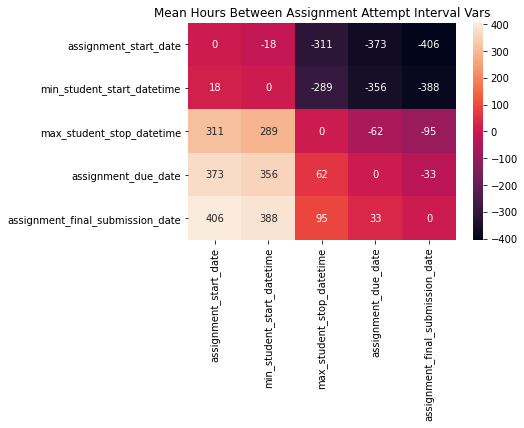

In [11]:
# attemptIntVars = [i for i in allIntVars if i not in cats['assignmentAttemptVars']]
attemptIntVars = [
'assignment_start_date',
'min_student_start_datetime',
'max_student_stop_datetime',
'assignment_due_date',
'assignment_final_submission_date',
]

util.date_diff_map(sampDf.select(attemptIntVars).toPandas(), "Mean Hours Between Assignment Attempt Interval Vars", 'h')

- Sequence of dates
  - assignment_start_date
  - min_student_start_datetime (+25 hours)
  - max_student_stop_datetime (+325 hours, 13 days)
  - assignment_due_date (+38 hours)
  - assignment_final_submission_date (+46 hours)
